In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

# 1. Loading data and carry out EDA

In [2]:
###loading data

df = pd.read_csv("data.csv")
df['date'] = pd.to_datetime(df['date'])
#df.set_index(['date'], inplace=True)

First we want to understand the structure of the data. How many tickers, historical data points, etc.

In [3]:
# Basic stats
ticker_summary = df['ticker'].describe()
print(f'\nSummary:\n{ticker_summary}')

# tickers and their counts
common_companies = df['ticker'].value_counts()
print(f'Most common companies:\n{common_companies}')

# Check null values
null_values = df['ticker'].isnull().sum()
print(f'Number of null/missing values: {null_values}')


Summary:
count      451113
unique        248
top       1332 JT
freq         2005
Name: ticker, dtype: object
Most common companies:
ticker
1332 JT    2005
8053 JT    2005
7011 JT    2005
7012 JT    2005
7013 JT    2005
           ... 
8815 JT     180
8697 JT     157
9434 JT     114
3659 JT      95
3893 JT      55
Name: count, Length: 248, dtype: int64
Number of null/missing values: 0


According to the summary, we have 248 tickers with most of contains data points of 2005.Smaller datasize might indicate later listing date.

# 2. convert data to date, ticker as index

In [4]:
##set index
df.set_index(['ticker', 'date'], inplace=True)

# Sort the data for efficient slicing
df.sort_index(inplace=True)

In [5]:
df

last    volume
ticker  date                            
1332 JT 2013-01-04    169.0987   1464100
        2013-01-07    166.3266   1783500
        2013-01-08    166.3266   1759800
        2013-01-09    165.4026    767800
        2013-01-10    167.2507   1503100
...                        ...       ...
9984 JT 2021-03-15  10370.0000  12041200
        2021-03-16  10620.0000  11346000
        2021-03-17  10400.0000   9771000
        2021-03-18  10220.0000  13941600
        2021-03-19   9969.0000  20715700

[451113 rows x 2 columns]

# 3. Analysis MA for each ticker

In [6]:
short_window = 5
long_window = 15

# Group by ticker and apply the moving average calculations for each company
def calculate_moving_averages(group):
    group['short_mavg'] = group['last'].rolling(window=short_window, min_periods=1).mean()
    group['long_mavg'] = group['last'].rolling(window=long_window, min_periods=1).mean()
    return group

df = df.groupby(level='ticker').apply(calculate_moving_averages).reset_index(level=0, drop=True)

In [7]:
df

last    volume    short_mavg     long_mavg
ticker  date                                                        
1332 JT 2013-01-04    169.0987   1464100    169.098700    169.098700
        2013-01-07    166.3266   1783500    167.712650    167.712650
        2013-01-08    166.3266   1759800    167.250633    167.250633
        2013-01-09    165.4026    767800    166.788625    166.788625
        2013-01-10    167.2507   1503100    166.881040    166.881040
...                        ...       ...           ...           ...
9984 JT 2021-03-15  10370.0000  12041200  10309.000000  10243.666667
        2021-03-16  10620.0000  11346000  10407.000000  10249.666667
        2021-03-17  10400.0000   9771000  10463.000000  10277.533333
        2021-03-18  10220.0000  13941600  10449.000000  10267.866667
        2021-03-19   9969.0000  20715700  10315.800000  10272.800000

[451113 rows x 4 columns]

In [8]:
# Calculate signals for each company
def calculate_signals(group):
    group['signal'] = 0
    group['signal'][short_window:] = np.where(group['short_mavg'][short_window:] > group['long_mavg'][short_window:], 1, 0)
    group['positions'] = group['signal'].diff()
    return group

df = df.groupby(level='ticker').apply(calculate_signals).reset_index(level=0, drop=True)
df

last    volume    short_mavg     long_mavg  signal  \
ticker  date                                                                   
1332 JT 2013-01-04    169.0987   1464100    169.098700    169.098700       0   
        2013-01-07    166.3266   1783500    167.712650    167.712650       0   
        2013-01-08    166.3266   1759800    167.250633    167.250633       0   
        2013-01-09    165.4026    767800    166.788625    166.788625       0   
        2013-01-10    167.2507   1503100    166.881040    166.881040       0   
...                        ...       ...           ...           ...     ...   
9984 JT 2021-03-15  10370.0000  12041200  10309.000000  10243.666667       1   
        2021-03-16  10620.0000  11346000  10407.000000  10249.666667       1   
        2021-03-17  10400.0000   9771000  10463.000000  10277.533333       1   
        2021-03-18  10220.0000  13941600  10449.000000  10267.866667       1   
        2021-03-19   9969.0000  20715700  10315.800000  10272.800000       1   

                    positions  
ticker  date                   
1332 JT 2013-01-04        NaN  
        2013-01-07        0.0  
        2013-01-08        0.0  
        2013-01-09        0.0  
        2013-01-10        0.0  
...                       ...  
9984 JT 2021-03-15        1.0  
        2021-03-16        0.0  
        2021-03-17        0.0  
        2021-03-18        0.0  
        2021-03-19        0.0  

[451113 rows x 6 columns]

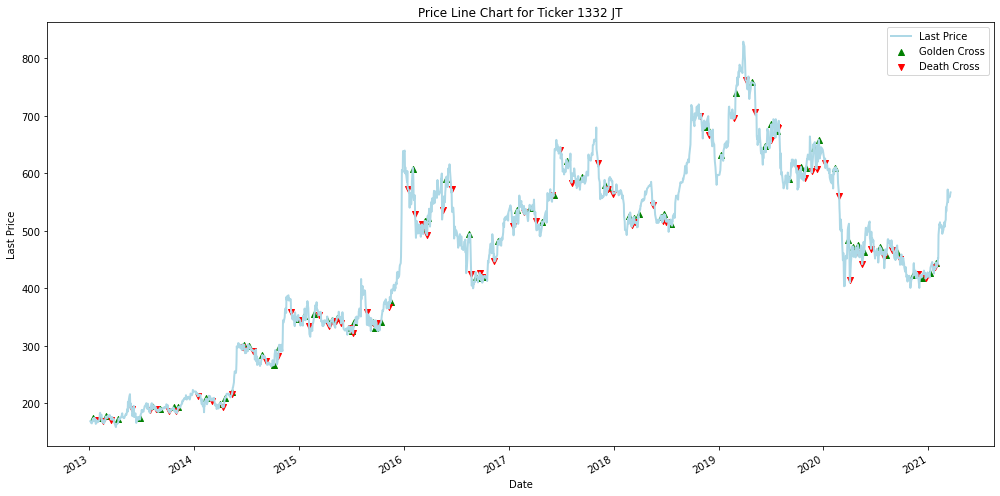

In [9]:
# Convert to numpy for compatibility
single_ticker_df = df.loc['1332 JT']#, level='ticker')

# Highlighting the crossovers
cross_over_up = (single_ticker_df['short_mavg'] >= single_ticker_df['long_mavg']) & (single_ticker_df['short_mavg'].shift(1) < single_ticker_df['long_mavg'].shift(1))
cross_over_down = (single_ticker_df['short_mavg'] <= single_ticker_df['long_mavg']) & (single_ticker_df['short_mavg'].shift(1) > single_ticker_df['long_mavg'].shift(1))


index_as_numpy = single_ticker_df.index.to_numpy()
last_prices_as_numpy = single_ticker_df['last'].to_numpy()
cross_over_up_as_numpy = cross_over_up.to_numpy()
cross_over_down_as_numpy = cross_over_down.to_numpy()

# Now use numpy arrays to index
plt.figure(figsize=(14,7))
plt.plot(index_as_numpy, single_ticker_df['last'].values, label='Last Price', color='lightblue', linewidth=2)
plt.scatter(index_as_numpy[cross_over_up_as_numpy], last_prices_as_numpy[cross_over_up_as_numpy], color='green', label='Golden Cross', marker='^', alpha=1)
plt.scatter(index_as_numpy[cross_over_down_as_numpy], last_prices_as_numpy[cross_over_down_as_numpy], color='red', label='Death Cross', marker='v', alpha=1)


# Adding titles and labels
plt.title('Price Line Chart for Ticker 1332 JT')
plt.xlabel('Date')
plt.ylabel('Last Price')
plt.legend()

plt.gcf().autofmt_xdate()

# Improving layout
plt.tight_layout()

# Show the plot
plt.show()

# 4. Construct a MA crossover strategy

In [10]:
#list all tickers
unique_tickers = df.index.get_level_values('ticker').unique()
unique_tickers

Index(['1332 JT', '1333 JT', '1334 JT', '1605 JT', '1721 JT', '1801 JT',
       '1802 JT', '1803 JT', '1808 JT', '1812 JT',
       ...
       '9503 JT', '9531 JT', '9532 JT', '9602 JT', '9613 JT', '9681 JT',
       '9735 JT', '9766 JT', '9983 JT', '9984 JT'],
      dtype='object', name='ticker', length=248)

In [11]:
# Iterate through the DataFrame and update the 'signal' field based on MA crossover logic
for tick in unique_tickers:
    ticker_data = df[df.index == tick]
    ticker_data = ticker_data.sort_values('date')  # Ensure data is sorted by date
    ticker_data['signal'] = np.where(ticker_data['short_mavg'] > ticker_data['long_mavg'], 1, 0)
    ticker_data['positions'] = ticker_data['signal'].diff()

    # Place this back into the main DataFrame
    df.loc[ticker_data.index, 'signal'] = ticker_data['signal']
    df.loc[ticker_data.index, 'positions'] = ticker_data['positions']

# 5. Backtesting

### Calculate daily returns

In [13]:
# Initialize variables
initial_investment = 10000.0
cash = initial_investment
holdings = 0.0
portfolio_values = []

# Simulate the strategy
for index, row in df.iterrows():
    # Update portfolio value at the start of the day before any trades
    portfolio_value = cash + holdings * row['last']
    portfolio_values.append(portfolio_value)

    # Check if we have a buy signal
    if row['positions'] == 1:
        # Buy only if we have cash for at least one share
        if cash >= row['last']:
            number_of_shares = int(cash / row['last'])
            holdings += number_of_shares
            cash -= number_of_shares * row['last']
    
    # Check if we have a sell signal
    elif row['positions'] == -1 and holdings > 0:
        # Sell all our holdings
        cash += holdings * row['last']
        holdings = 0.0

# Add the portfolio values to the DataFrame
df['portfolio_value'] = portfolio_values

# Calculate daily returns
df['daily_returns'] = df['portfolio_value'].pct_change()

Final portfolio value: $259,380.33
Return on investment: 2493.80%


In [14]:
np0 = df['daily_returns'].groupby('date').sum().to_numpy()
np1 = df['portfolio_value'].groupby('date').sum().to_numpy()

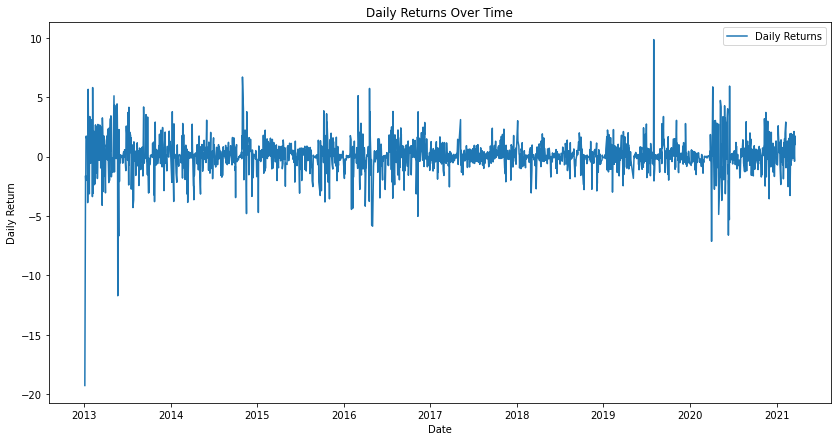

In [15]:
# Plot the daily returns
plt.figure(figsize=(14, 7))
plt.plot(index_as_numpy, np0, label='Daily Returns')
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

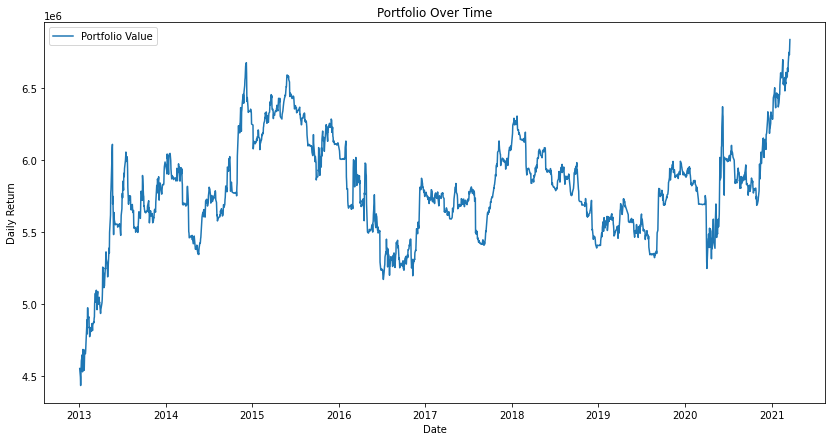

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(index_as_numpy, np1, label='Portfolio Value')
plt.title('Portfolio Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

In [17]:
# Final portfolio value after the loop
portfolio_value = cash + holdings * df.iloc[-1]['last']
print(f"Final portfolio value: ${portfolio_value:,.2f}")
print(f"Return on investment: {((portfolio_value - initial_investment) / initial_investment) * 100:.2f}%")

Final portfolio value: $259,380.33
Return on investment: 2493.80%
